In [60]:
import csv
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import seaborn as sns
import matplotlib.pyplot as plt

In [61]:
n_people = 10
states = ["active", "meditate", "neutral"]
n_samples_per_state = 8

class Sample:
    def __init__(self):
        self.data = {
            'RawEEG': [],
            'Alpha': [],
            'Low Beta': [],
            'High Beta': [],
            'Gamma': [],
            'Theta': [],
            'Delta': [],
            'Meditation': [],
            'Attention': []
        }

    def recordDataPoint(self, RawEEG, Attention, Meditation, Alpha, Delta, Theta, LowBeta, HighBeta, Gamma):
        self.data['RawEEG'].append(float(RawEEG))
        self.data['Attention'].append(float(Attention))
        self.data['Meditation'].append(float(Meditation))
        self.data['Alpha'].append(float(Alpha))
        self.data['Delta'].append(float(Delta))
        self.data['Theta'].append(float(Theta))
        self.data['Low Beta'].append(float(LowBeta))
        self.data['High Beta'].append(float(HighBeta))
        self.data['Gamma'].append(float(Gamma))

    '''
    Record a line of data from the CSV output, which takes form RawEEG, Alpha, Delta, Gamma, Low Beta, High Beta, Theta, Attention, Meditation

    '''
    def recordDataLine(self, line):
        self.recordDataPoint(line[0], line[7], line[8], line[1], line[2], line[6], line[4], line[5], line[3])
    
    def getEEG(self):
        return self.data['RawEEG']
    
    def getAttention(self):
        return self.data["Attention"]
    
    def getMeditation(self):
        return self.data["Meditation"]
    
    def getAlpha(self):
        return self.data["Alpha"]
    
    def getDelta(self):
        return self.data["Delta"]
    
    def getTheta(self):
        return self.data["Theta"]
    
    def getLowBeta(self):
        return self.data["Low Beta"]
    
    def getHighBeta(self):
        return self.data["High Beta"]
    
    def getGamma(self):
        return self.data["Gamma"]

    def get(self, key):
        return self.data[key]

    '''
    Filter out all outliers, as defined by being outside 3*std from the mean, and replace with mean of the samples around them
    '''
    def filter_outliers(self):
        for key in self.data:
            data = self.data[key]
            
            filtered = []
            for i, x in enumerate(data):
                if abs(x - np.mean(data)) < 3 * np.std(data):
                    filtered.append(x)
                else:
                    filtered.append(np.mean(data[max(0, i-2):i] + data[i+1:min(len(data), i+2)]))
            self.data[key] = filtered

            # self.data[key] = [x for x in self.data[key] if abs(x - np.mean(self.data[key])) < 3 * np.std(self.data[key])]


In [62]:
data = []
dataLabels = []

def transcribeFileToSample(personN: int, sampleN: int, state: str):
    sample_data = Sample()

    with open(f"data/all_data/{state}_{personN}_{sampleN}.csv") as f:
        reader = csv.reader(f)

        header = next(reader)
        
        for row in reader:
            sample_data.recordDataLine(row)

        sample_data.filter_outliers()

        data.append(sample_data)
        dataLabels.append(personN)

for person in range(n_people):
    for state in states:
        for i in range(n_samples_per_state):
            transcribeFileToSample(person + 1, i + 1, state)

In [63]:
dataExtracted = []

for point in data:
    extractedPoint = []

    extractedPoint.append(np.mean(point.getAlpha()))
    extractedPoint.append(np.mean(point.getLowBeta()))
    extractedPoint.append(np.std(point.getAlpha()))
    extractedPoint.append(np.mean(point.getTheta()))
    extractedPoint.append(np.std(point.getGamma()))
    extractedPoint.append(np.std(point.getDelta()))

    dataExtracted.append(extractedPoint)

In [64]:
# K-fold cross validation (k=5)
cvclf = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components=1))
scores = cross_val_score(cvclf, dataExtracted, dataLabels, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.50 accuracy with a standard deviation of 0.08


In [65]:
total = 0
n = 100

errorLabels = np.zeros((n_people, n_people), dtype=int)

In [66]:
for _ in range(n):
    train, test, trainLabels, testLabels = train_test_split(dataExtracted, dataLabels, test_size=0.20)

    clf = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components=1))
    clf.fit(train, trainLabels)

    predictions = clf.predict(test)

    for prediction, actual in zip(predictions, testLabels):
        if prediction != actual:
            errorLabels[actual - 1][prediction - 1] += 1
    
    total += clf.score(test, testLabels)

print(f"Score: {total / n}")

Score: 0.5247916666666668


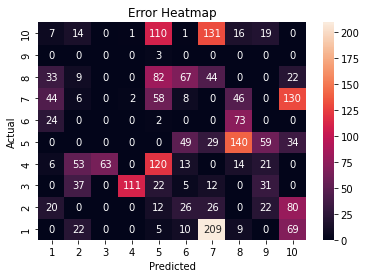

In [67]:
# Create a heatmap to show which people are predicted wrongly the most
ax = sns.heatmap(errorLabels, xticklabels=range(1, n_people + 1), yticklabels=range(1, n_people + 1), annot=True, fmt="d")
ax.invert_yaxis()
plt.title("Error Heatmap")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()